In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_dir = root_dir + '/Data/Data.zip (Unzipped Files)/Data/'

In [0]:
from fastai.vision import *

In [0]:
path = Path(base_dir)

path_lbl = Path(base_dir +'Mask') # There are two folders: 'images' & 'labels'
path_img = Path(base_dir + 'Green')

In [0]:
imgs = get_image_files(path_img)
lbls = get_image_files(path_lbl)

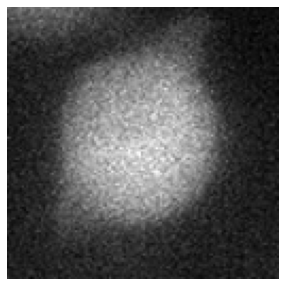

In [17]:
img_f = imgs[500]
img = open_image(img_f)
img.show(figsize=(5, 5))

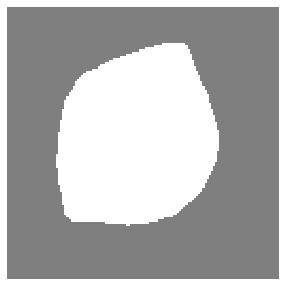

In [18]:
msk = open_mask(lbls[500])
msk.show(figsize=(5,5), cmap = 'gray')

In [19]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_M{x.suffix}'
print(get_y_fn(img_f))

/content/gdrive/My Drive/Data/Data.zip (Unzipped Files)/Data/Mask/InpGreen_ 1006_M.png


In [20]:
codes = np.loadtxt(path/'codes.txt', dtype=str) # Load data codes
len(codes), codes

(2, array(['Background', 'Cell'], dtype='<U10'))

In [0]:
src_size = np.array(msk.shape[1:])
size = src_size//2
bs = 16

src = (SegmentationItemList.from_folder(path_img)
       # Load in x data from folder
       .split_by_rand_pct(valid_pct=0.3)
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)

In [22]:
src

LabelLists;

Train: LabelList (1050 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /content/gdrive/My Drive/Data/Data.zip (Unzipped Files)/Data/Green;

Valid: LabelList (450 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /content/gdrive/My Drive/Data/Data.zip (Unzipped Files)/Data/Green;

Test: None

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

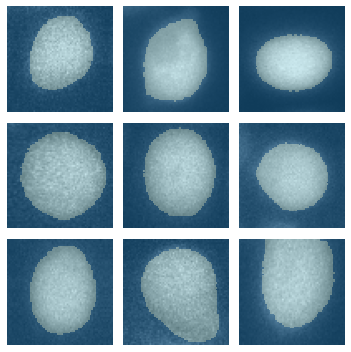

In [25]:
data.show_batch(rows=3, figsize=(5, 5))

In [26]:
learn = unet_learner(data, models.resnet34, wd=1e-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time
0,0.414059,#na#,05:35


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


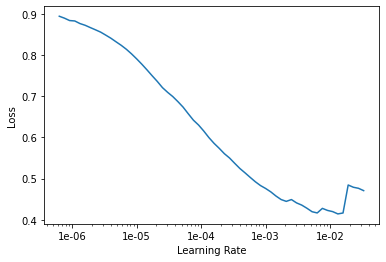

In [27]:
learn.lr_find() # find learning rate
learn.recorder.plot()

In [28]:
lr = 3e-3 # pick a lr
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) # train model

epoch,train_loss,valid_loss,time
0,0.163205,0.114755,02:46
1,0.139109,0.103648,00:15
2,0.125622,0.099053,00:14
3,0.126115,0.110846,00:15
4,0.131214,0.102775,00:15
5,0.125132,0.109595,00:15
6,0.118733,0.093631,00:14
7,0.117754,0.092234,00:15
8,0.113986,0.097712,00:15
9,0.106156,0.080323,00:15


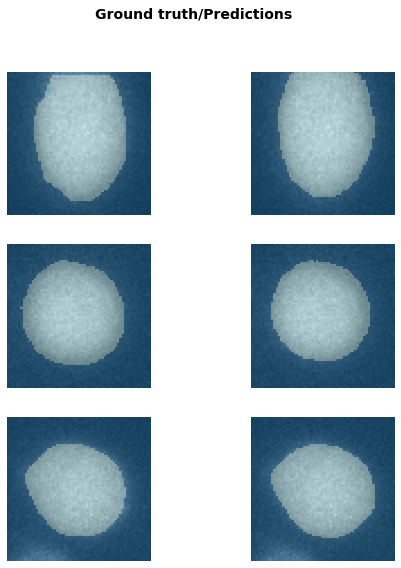

In [30]:
learn.save('J_Cell_segmentation') # save model
learn.show_results(rows=3, figsize=(8, 9))

epoch,train_loss,valid_loss,time
0,0.096814,0.079250,00:16
1,0.095508,0.078531,00:16
2,0.096118,0.079554,00:16
3,0.095127,0.078264,00:16
4,0.093122,0.077707,00:16
5,0.093371,0.076061,00:16
6,0.091445,0.075441,00:16
7,0.091743,0.077210,00:16
8,0.092694,0.076649,00:16
9,0.093735,0.079067,00:16


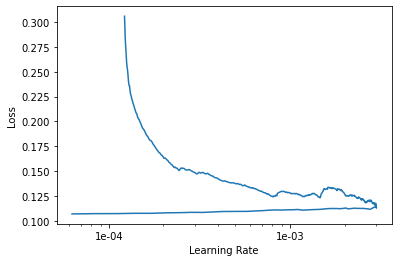

In [31]:
learn.unfreeze() # unfreeze all layers

# find and plot lr again
learn.unfreeze()
learn.recorder.plot()

# train model 
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

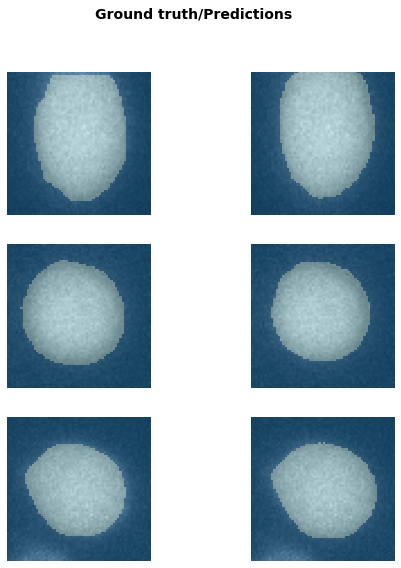

In [32]:
learn.save('J_Cell_segmentation_unfreezed') # save model
learn.show_results(rows=3, figsize=(8, 9))

In [33]:
learn.load('J_Cell_segmentation_unfreezed')

Learner(data=ImageDataBunch;

Train: LabelList (1050 items)
x: SegmentationItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: SegmentationLabelList
ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64)
Path: /content/gdrive/My Drive/Data/Data.zip (Unzipped Files)/Data/Green;

Valid: LabelList (450 items)
x: SegmentationItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: SegmentationLabelList
ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64)
Path: /content/gdrive/My Drive/Data/Data.zip (Unzipped Files)/Data/Green;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [0]:
learn.export()

In [0]:
fnames = get_image_files(base_dir + 'Green')

for fileName in fnames:
    try:
        img = open_image(fileName)
        p,img_hr,b = learn.predict(img)
    except:
        print(str(fileName)[:34]+str(fileName)[-18:])
        continue
    
    try:
        Image(img_hr).save(str(fileName)[:35]+str(fileName)[-16:])
    except:
        print(str(fileName)[:34]+str(fileName)[-18:])
        continue